# Language Technology - 5th Tutorial on RNNs for Text Classification with Keras


----
## Important Resources

Language Technology Resources: https://eclass.aueb.gr/modules/document/index.php?course=INF210

Python Official Documentation: https://docs.python.org/3.5/

Keras: https://keras.io/

Keras examples: https://github.com/fchollet/keras/tree/master/examples

----

## Tutorial 5 Schedule

**In order to familiarize ourselves with Neural Networks, we have the following sections:**

* **Use of pre-trained word embeddings**
* **Text Classification based on RNNs**
    
---

## Use of pre-trained word embeddings

In [1]:
from gensim.models import KeyedVectors

def PretrainedEmbedding(word_embeddings_path=None):
    embeddings = KeyedVectors.load_word2vec_format(word_embeddings_path, binary=True)
    word_encodings_weights = np.concatenate((np.zeros((1, embeddings.vectors.shape[-1]), dtype=np.float32), 
                                             embeddings.vectors), axis=0)
    embedding_layer = Embedding(len(word_encodings_weights), word_encodings_weights.shape[-1],
                                weights=[word_encodings_weights], trainable=False, name='pretrained_embeddings')

    return embedding_layer

## Load IMDB dataset with GloVe IDs

Again we will use the IMDB binary sentiment analysis datasets.

**Python Example Code**

In [4]:
from keras.datasets import imdb

# Load IMDB Dataset
vocab_size = 100000
maxlen = 100

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Load IMDB vocabulary
imdb_index = {index: word for word, index in imdb.get_word_index().items()}
print(len(imdb_index), 'tokens in vocabulary')

# Load 200-dimensional GloVe embeddings index
import pickle

with open('/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.index', 'rb') as file:
    glove_index = pickle.load(file)


# Build datasets with GloVe word indices

import numpy as np

x_train_v2 = np.zeros((len(x_train), maxlen,), dtype=np.int32)
for i, sample in enumerate(x_train):
    for j, token_index in enumerate(sample[:maxlen]):
        # If word in vocabylary
        if token_index - 3 in imdb_index and imdb_index[token_index - 3] in glove_index:
            x_train_v2[i][j] = glove_index[imdb_index[token_index - 3]]
            
x_test_v2 = np.zeros((len(x_test), maxlen,), dtype=np.int32)
for i, sample in enumerate(x_test):
    for j, token_index in enumerate(sample[:maxlen]):
        # If word in vocabylary
        if token_index - 3 in imdb_index and imdb_index[token_index - 3] in glove_index:
            x_test_v2[i][j] = glove_index[imdb_index[token_index - 3]]

print('x_train shape:', x_train_v2.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test_v2.shape)
print('y_test shape:', y_test.shape)


Loading data...
25000 train sequences
25000 test sequences
88584 tokens in vocabulary
x_train shape: (25000, 100)
y_train shape: (25000,)
x_test shape: (25000, 100)
y_test shape: (25000,)


## Text Classification Architectures based on RNNs

First we are going to implement RNN-based architectures. 

Keras, as any other deep learning framework, provides three alternative RNN layers:

* Simple RNNs
* GRUs
* LSTMs

For both GRUs and LSTMs we also have access to GPU-accelerated layers called CUDNN-GRU, CUDNN-LSTM. These layers are optimized for NVIDIA GPUs and run up to 20x, when such hardware is accesible.

RNNs performing over word sequences produce one new representation for each token (timestep).  In order to exploit RNNs for text classification, we need to build a unique fixed-size representation for the whole sequence. There are three main alternatives in order to do so: 

* Use the concatenation of the last hidden states of both directions in a bidirectional LSTM.
* Use a pooling mechanism over time (e.g., MaxPooling, MeanPooling)
* Use the concatenation of more than one of the aforementioned mechanisms.
* Use self-attention mechanisms.


---

### Concat last states of LSTMs

**Python Example Code**

In [6]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Dense

inputs =  Input(shape=(100, ), dtype='int32')
embeddings = Embedding(20000, 50, input_length=100)(inputs)

dropped_embeddings = Dropout(rate=0.2)(embeddings)

# Add stack of bidirectional LSTMs
# 1st bi-LSTM (returns the LSTM outputs for each token)
lstms_1 = Bidirectional(LSTM(100, return_sequences=True))(dropped_embeddings)
# 2nd bi-LSTM (returns concatenation of bi-LSTM for the first and last token)
lstms_2 = Bidirectional(LSTM(100))(lstms_1)
outputs = Dense(1, activation='sigmoid')(lstms_2)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_2 (InputLayer)                             (None, 100)                                 0                
______________________________________________________________________________________________________________
embedding_2 (Embedding)                          (None, 100, 50)                             1000000          
______________________________________________________________________________________________________________
dropout_2 (Dropout)                              (None, 100, 50)                             0                
______________________________________________________________________________________________________________
bidirectional_3 (Bidirectional)                  (None, 100, 200)                            120800           
_

### MaxPooling / AveragePooling over LSTMs

**Python Example Code**

In [7]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM
from keras.layers import Dense, GlobalMaxPooling1D, GlobalAveragePooling1D

inputs =  Input(shape=(100, ), dtype='int32')
embeddings = Embedding(20000, 50, input_length=100)(inputs)

dropped_embeddings = Dropout(rate=0.2)(embeddings)

# Add stack of bidirectional LSTMs
# 1st bi-LSTM (returns the LSTM outputs for each token)
lstms_1 = Bidirectional(LSTM(100, return_sequences=True))(dropped_embeddings)
# 2nd bi-LSTM (returns the LSTM outputs for each token)
lstms_2 = Bidirectional(LSTM(100, return_sequences=True))(lstms_1)
# MaxPooling over 100 timesteps
max_pool = GlobalMaxPooling1D()(lstms_2)
# mean_pool = GlobalAveragePooling1D()(lstms_2)
outputs = Dense(1, activation='sigmoid')(max_pool)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_3 (InputLayer)                             (None, 100)                                 0                
______________________________________________________________________________________________________________
embedding_3 (Embedding)                          (None, 100, 50)                             1000000          
______________________________________________________________________________________________________________
dropout_3 (Dropout)                              (None, 100, 50)                             0                
______________________________________________________________________________________________________________
bidirectional_5 (Bidirectional)                  (None, 100, 200)                            120800           
_

### Use all together (MaxPool, AveragePool,  last LSTMs)  - ULMFit architecture

**Python Example Code**

In [9]:
from keras.models import Model
import keras. backend as K
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM
from keras.layers import Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Lambda, concatenate

GLOVE_PATH = '/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.bin'

inputs =  Input(shape=(100, ), dtype='int32', name='word_ids')
embeddings = PretrainedEmbedding(GLOVE_PATH)(inputs)
dropped_embeddings = Dropout(rate=0.2, name='dropout')(embeddings)
# Add stack of bidirectional LSTMs
# 1st bi-LSTM (returns the LSTM outputs for each token)
lstms_1 = Bidirectional(LSTM(64, return_sequences=True), name='1st_bilstm')(dropped_embeddings)
# 2nd bi-LSTM (returns the LSTM outputs for each token)
lstms_2 = Bidirectional(LSTM(64, return_sequences=True), name='2nd_bilstm')(lstms_1)
# Get the 64-dimensional output vector of the forward LSTM in 100th position
last_lstm = Lambda(lambda x: K.tf.squeeze(x[:, -1:, 64:], axis=1), name='last_lstm_outputs')(lstms_2)
# get the 64-dimensional output vector of the backward LSTM in 1st position
first_lstm = Lambda(lambda x: K.tf.squeeze(x[:, 0:1, :64], axis=1), name='first_lstm_outputs')(lstms_2)
# MaxPooling over 100 timesteps
max_pool = GlobalMaxPooling1D(name='max_pooling')(lstms_2)
# AveragePooling over 100 timesteps
avg_pool = GlobalAveragePooling1D(name='avg_pooling')(lstms_2)
document_encoding = concatenate([max_pool, avg_pool, first_lstm, last_lstm], name='concat')
document_encoding =  Dropout(rate=0.2, name='output_dropout')(document_encoding)
outputs = Dense(1, activation='sigmoid', name='output')(document_encoding)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
word_ids (InputLayer)               (None, 100)             0                                                 
______________________________________________________________________________________________________________
pretrained_embeddings (Embedding)   (None, 100, 200)        80000600     word_ids[0][0]                       
______________________________________________________________________________________________________________
dropout (Dropout)                   (None, 100, 200)        0            pretrained_embeddings[0][0]          
______________________________________________________________________________________________________________
1st_bilstm (Bidirectional)          (None, 100, 128)        135680       dropout[0][0]                        
_

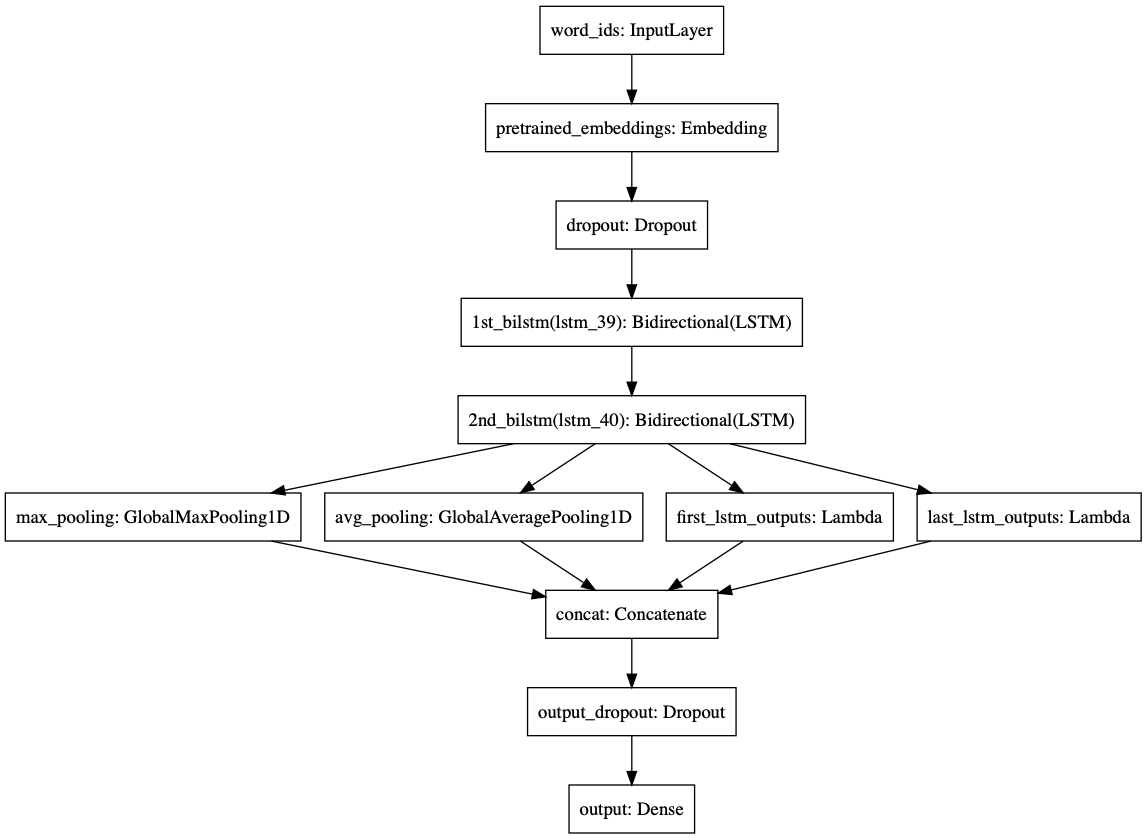

In [64]:
%matplotlib notebook

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')

### Train ULMFit-like model from scratch

In [65]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile model
model.compile(optimizer=Adam(lr=0.001, clipvalue=2.0), loss='binary_crossentropy', metrics=['accuracy'])

# Initialize callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='CHECKPOINT_1.hdf5', monitor='val_loss', mode='auto',
                                   verbose=1, save_best_only=True, save_weights_only=True)

# Train model with callbacks
print('Train...')
history = model.fit(x_train_v2, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    validation_data=(x_test_v2, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 220s 9ms/step - loss: 0.4863 - acc: 0.7582 - val_loss: 0.4268 - val_acc: 0.8017

Epoch 00001: val_loss improved from inf to 0.42685, saving model to CHECKPOINT_1.hdf5
Epoch 2/15
25000/25000 [==============================] - 204s 8ms/step - loss: 0.4073 - acc: 0.8117 - val_loss: 0.4039 - val_acc: 0.8131

Epoch 00002: val_loss improved from 0.42685 to 0.40385, saving model to CHECKPOINT_1.hdf5
Epoch 3/15
25000/25000 [==============================] - 207s 8ms/step - loss: 0.3769 - acc: 0.8287 - val_loss: 0.3723 - val_acc: 0.8288

Epoch 00003: val_loss improved from 0.40385 to 0.37234, saving model to CHECKPOINT_1.hdf5
Epoch 4/15
25000/25000 [==============================] - 209s 8ms/step - loss: 0.3471 - acc: 0.8457 - val_loss: 0.3672 - val_acc: 0.8332

Epoch 00004: val_loss improved from 0.37234 to 0.36721, saving model to CHECKPOINT_1.hdf5
Epoch 5/15
25000/25000 [=====

<IPython.core.display.Javascript object>


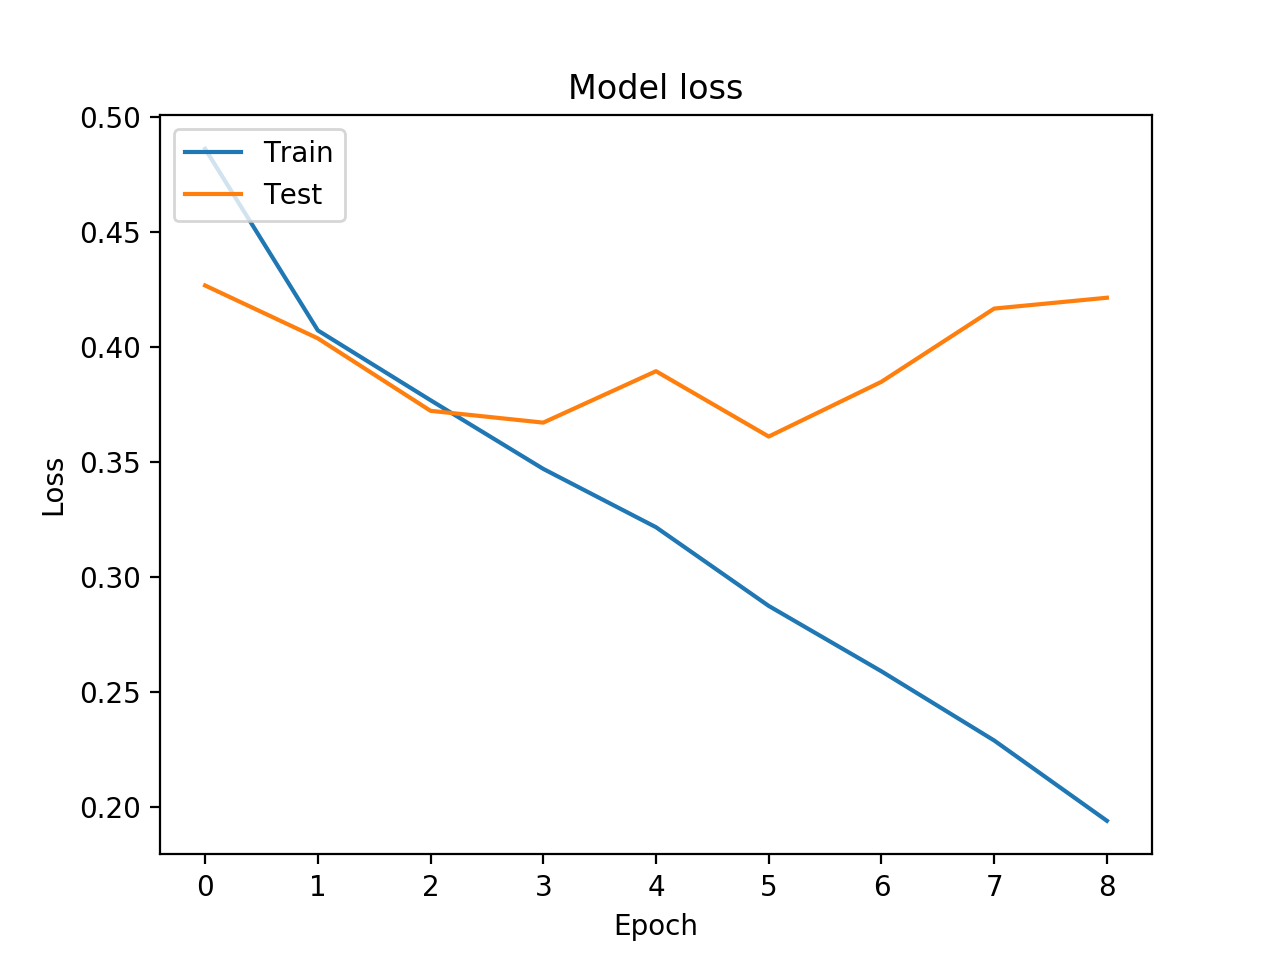

In [66]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
from sklearn import metrics

# Evaluate
y_prob = model.predict(x_test_v2, batch_size=1, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12500
           1       0.83      0.85      0.84     12500

   micro avg       0.84      0.84      0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### Self-Attention over LSTMs

First we need to implement a new custom layer for attention mechanisms.

**Python Example Code**

In [5]:
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers.core import Layer
import numpy as np


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class SimpleAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(ContextualAttention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

Then, we can use attention layers, like any other predefined layer provided by Keras.

**Python Example Code**

In [6]:
from keras.models import Model
import keras. backend as K
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM
from keras.layers import Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Lambda, concatenate

GLOVE_PATH = '/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.bin'

inputs =  Input(shape=(100, ), dtype='int32', name='word_ids')
embeddings = PretrainedEmbedding(GLOVE_PATH)(inputs)
dropped_embeddings = Dropout(rate=0.2, name='dropout')(embeddings)
# Add stack of bidirectional LSTMs
# 1st bi-LSTM
lstms_1 = Bidirectional(LSTM(64, return_sequences=True), name='1st_bilstm')(dropped_embeddings)
# 2nd bi-LSTM
lstms_2 = Bidirectional(LSTM(64, return_sequences=True), name='2nd_bilstm')(lstms_1)
document_encoding =  SimpleAttention()(lstms_2)
document_encoding =  Dropout(rate=0.2, name='output_dropout')(document_encoding)
outputs = Dense(1, activation='sigmoid', name='output')(document_encoding)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
word_ids (InputLayer)                            (None, 100)                                 0                
______________________________________________________________________________________________________________
pretrained_embeddings (Embedding)                (None, 100, 200)                            80000600         
______________________________________________________________________________________________________________
dropout (Dropout)                                (None, 100, 200)                            0                
______________________________________________________________________________________________________________
1st_bilstm (Bidirectional)                       (None, 100, 128)                            135680           
_